In [11]:
import os
import zipfile
import pandas as pd
from io import TextIOWrapper


def parse_zip(zip_path):
    dfs = {}
    with zipfile.ZipFile(zip_path) as z:
        for name in z.namelist():
            if not name.endswith(".dat"):
                continue

            base = os.path.basename(name)
            with z.open(name) as f:
                if base == "users.dat":
                    cols = ["UserID", "Gender", "Age", "Occupation", "ZipCode"]

                elif base == "ratings.dat":
                    cols = ["UserID", "MovieID", "Rating", "Timestamp"]

                elif base == "movies.dat":
                    cols = ["MovieID", "Title", "Genres"]

                df = pd.read_csv(
                    TextIOWrapper(f, encoding="latin-1"),
                    sep="::",
                    engine="python",
                    header=None,
                    names=cols,
                )

                dfs[base.replace(".dat", "")] = df

    return dfs


dfs = parse_zip("ml-1m.zip")
users = dfs["users"]
movies = dfs["movies"]
ratings = dfs["ratings"]

merged_df = ratings.merge(users, on="UserID").merge(movies, on="MovieID")
merged_df

merged_df

,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,ZipCode,Title,Genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,F,1,10,48067,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,F,1,10,48067,My Fair Lady (1964),Musical|Romance
3,1,3408,4,978300275,F,1,10,48067,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,F,1,10,48067,"Bug's Life, A (1998)",Animation|Children's|Comedy
...,...,...,...,...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,M,25,6,11106,Weekend at Bernie's (1989),Comedy
1000205,6040,1094,5,956704887,M,25,6,11106,"Crying Game, The (1992)",Drama|Romance|War
1000206,6040,562,5,956704746,M,25,6,11106,Welcome to the Dollhouse (1995),Comedy|Drama
1000207,6040,1096,4,956715648,M,25,6,11106,Sophie's Choice (1982),Drama


1.Требуется вычислить средние рейтинги для фильма с ID = № варианта в зависимости от пола;

Вариант 17

In [20]:
variant = 17

my_film_df = merged_df[merged_df["MovieID"] == variant]

merged_df[merged_df["MovieID"] == 17]
# my_film_df.groupby("Gender")["Rating"].mean()

,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,ZipCode,Title,Genres
501,6,17,4,978236383,F,50,9,55117,Sense and Sensibility (1995),Drama|Romance
657,8,17,4,978229571,M,25,12,11413,Sense and Sensibility (1995),Drama|Romance
2057,18,17,4,978156535,F,18,3,95825,Sense and Sensibility (1995),Drama|Romance
2353,19,17,4,978554393,M,1,10,48073,Sense and Sensibility (1995),Drama|Romance
4070,30,17,4,978121841,F,35,7,19143,Sense and Sensibility (1995),Drama|Romance
...,...,...,...,...,...,...,...,...,...,...
997636,6025,17,5,956731134,F,25,1,32607,Sense and Sensibility (1995),Drama|Romance
998212,6032,17,5,956718484,M,45,7,55108,Sense and Sensibility (1995),Drama|Romance
999036,6036,17,4,956712981,F,25,15,32603,Sense and Sensibility (1995),Drama|Romance
999616,6037,17,4,956709701,F,45,1,76006,Sense and Sensibility (1995),Drama|Romance


2.Отобрать фильмы, получившие не менее 250 оценок, и для них определить средний
рейтинг в зависимости от пола;
Результат вывести в виде DataFrame с колонками
['MovieID', 'Title', 'Rating_F', 'Rating_M']

In [13]:
# Group movies by qnty of rates >=250
mov_id_gb = merged_df.groupby("MovieID").size()
mov_id_gb = mov_id_gb[mov_id_gb >= 250]

# Trim origin df by top movs
top_mov_df = merged_df[merged_df["MovieID"].isin(mov_id_gb.index)]


mean_rating_by_gender_gb = top_mov_df.groupby(["MovieID", "Title", "Gender"])[
    "Rating"
].mean()
mean_rating_by_gender_gb

# Assemble new df from mean ratings
mean_rating_df = mean_rating_by_gender_gb.unstack().reset_index().rename(columns={"F": "Rating_F", "M": "Rating_M"})
mean_rating_df.columns.name = None

mean_rating_df

,MovieID,Title,Rating_F,Rating_M
0,1,Toy Story (1995),4.187817,4.130552
1,2,Jumanji (1995),3.278409,3.175238
2,3,Grumpier Old Men (1995),3.073529,2.994152
3,5,Father of the Bride Part II (1995),3.212963,2.888298
4,6,Heat (1995),3.682171,3.909988
...,...,...,...,...
1211,3917,Hellraiser (1987),3.022222,3.128205
1212,3927,Fantastic Voyage (1966),3.535714,3.589041
1213,3948,Meet the Parents (2000),3.619048,3.641838
1214,3949,Requiem for a Dream (2000),3.950000,4.174107


3.Найти фильмы, оказавшиеся в топ 5 у зрителей-женщин и худшие 5 у зрителей-
мужчин. Найти фильмы (топ 5), по которым мужчины и женщины сильнее всего
разошлись в оценках;

In [14]:
top5_women = mean_rating_df.sort_values("Rating_F", ascending=False).head(5)
top5_women

top5_men = mean_rating_df.sort_values("Rating_M", ascending=True).head(5)
top5_men

mean_rating_df["Diff"] = (mean_rating_df["Rating_F"] - mean_rating_df["Rating_M"]).abs()
top_diff = mean_rating_df.sort_values("Diff", ascending=False).head(5)
top_diff

,MovieID,Title,Rating_F,Rating_M,Diff
313,1088,Dirty Dancing (1987),3.790378,2.959596,0.830782
352,1201,"Good, The Bad and The Ugly, The (1966)",3.494949,4.221300,0.726351
1186,3760,"Kentucky Fried Movie, The (1977)",2.878788,3.555147,0.676359
796,2468,Jumpin' Jack Flash (1986),3.254717,2.578358,0.676359
68,231,Dumb & Dumber (1994),2.697987,3.336595,0.638608


4.Определить фильмы (топ 5), вызвавшие в среднем наибольшее разногласие у зрителей
независимо от пола;

In [15]:
movie_std = merged_df.groupby(["MovieID", "Title"])["Rating"].std()
movie_std = movie_std.reset_index().rename(columns={"Rating": "Rating_Deviation"})
movie_std.sort_values("Rating_Deviation", ascending=False).head(5)


,MovieID,Title,Rating_Deviation
558,572,Foreign Student (1994),2.828427
3557,3800,Criminal Lovers (Les Amants Criminels) (1999),2.309401
1620,1787,Paralyzing Fear: The Story of Polio in America...,2.121320
676,706,Sunset Park (1996),2.121320
3012,3236,Zachariah (1971),2.121320


5.Определить средний рейтинг каждого жанра для различных возрастов. Установите,
фильмы какого жанра в каждой категории возрастов имеют наибольший и наименьший
рейтинги.

In [16]:
df_exploded = merged_df.copy()
df_exploded["Genres"] = df_exploded["Genres"].str.split("|").explode("Genres")

genre_age_mean = df_exploded.groupby(["Age", "Genres"])["Rating"].mean().reset_index()

max_by_age = genre_age_mean.iloc[genre_age_mean.groupby("Age")["Rating"].idxmax()]

min_by_age = genre_age_mean.iloc[genre_age_mean.groupby("Age")["Rating"].idxmin()]
display(max_by_age)
display(min_by_age)

,Age,Genres,Rating
7,1,Drama,3.596588
27,18,Film-Noir,3.533638
53,25,Western,3.568853
62,35,Fantasy,3.662492
81,45,Film-Noir,3.709176
96,50,Documentary,3.847458
114,56,Documentary,3.846154


,Age,Genres,Rating
9,1,Film-Noir,3.361607
24,18,Documentary,3.454787
44,25,Fantasy,3.498961
60,35,Documentary,3.545455
89,45,Western,3.568381
107,50,Western,3.657475
113,56,Crime,3.703628


Нормальное распределение

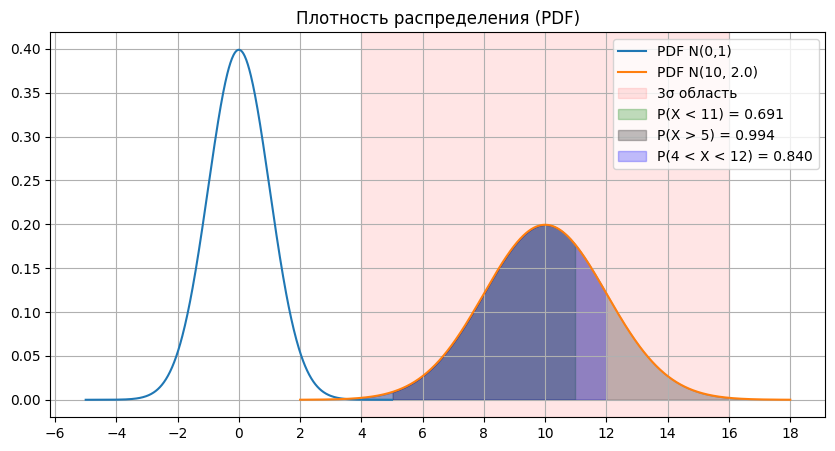

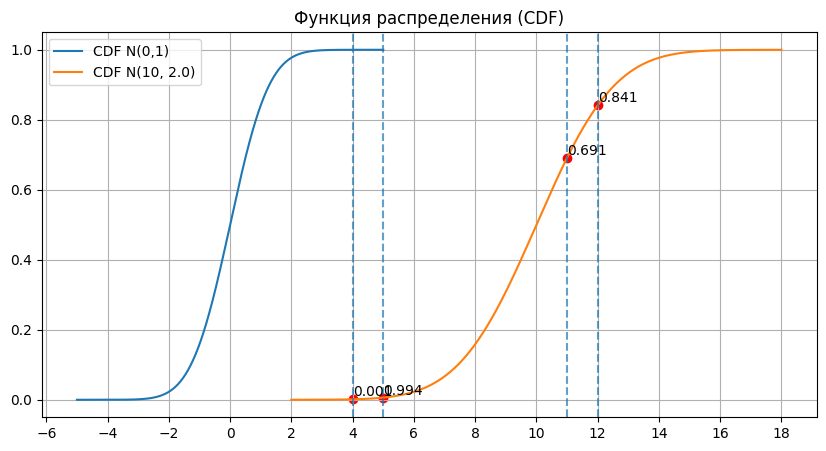

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

mu = 10  
variance = 4  
sigma = np.sqrt(variance)  

def normal_distribution(mu, sigma, probabilities=None, sigma_step=4, points=600):
    if probabilities is None:
        probabilities = [('less', 11), ('more', 5), ('between', 4, 12)] 
    
    z = np.linspace(-5, 5, points)  # z = (x - mu)/sigma
    pdf_z = norm.pdf(z)      
    cdf_z = norm.cdf(z)      

    x_min = mu - sigma_step * sigma
    x_max = mu + sigma_step * sigma
    x = np.linspace(x_min, x_max, points)
    pdf_x = norm.pdf(x, loc=mu, scale=sigma)
    cdf_x = norm.cdf(x, loc=mu, scale=sigma)

    results = {}
    for p in probabilities:
        if p[0] == 'less':     # P(X < b)
            b = p[1]
            val = norm.cdf(b, loc=mu, scale=sigma)
            results[f"P(X < {b})"] = val
        elif p[0] == 'more':   # P(X > a)
            a = p[1]
            val = 1 - norm.cdf(a, loc=mu, scale=sigma)
            results[f"P(X > {a})"] = val
        elif p[0] == 'between':  # P(a < X < b)
            a, b = p[1], p[2]
            val = norm.cdf(b, loc=mu, scale=sigma) - norm.cdf(a, loc=mu, scale=sigma)
            results[f"P({a} < X < {b})"] = val
        else:
            raise ValueError("Unknown command for probabilities")
        

    # правило 3-сигм
    left_3 = mu - 3 * sigma
    right_3 = mu + 3 * sigma

    return {
        "z": z, "pdf_z": pdf_z, "cdf_z": cdf_z,
        "x": x, "pdf_x": pdf_x, "cdf_x": cdf_x,
        "results": results,
        "three_sigma_interval": (left_3, right_3),
        "mu": mu,
        "sigma": sigma
    }

def plot_normal(data):
    z, pdf_z, cdf_z = data["z"], data["pdf_z"], data["cdf_z"]
    x, pdf_x, cdf_x = data["x"], data["pdf_x"], data["cdf_x"]
    left_3, right_3 = data["three_sigma_interval"]
    mu, sigma = data["mu"], data["sigma"]
    probs = data["results"]   # словарь вероятностей

    #  для нормированной и X
    plt.figure(figsize=(10, 5))
    plt.plot(z, pdf_z, label="PDF N(0,1)")
    plt.plot(x, pdf_x, label=f"PDF N({mu}, {sigma})")
    plt.locator_params(axis='x', nbins=15)

    # выделение области для правила трех сигм
    plt.axvspan(left_3, right_3, color='red', alpha=0.1, label="3σ область")

    prob_colors = {
    "less": "green",
    "more": "black",
    "between": "blue"
    }

    # добавление вероятностей на PDF
    for key, value in probs.items():
        # P(X < b)
        if key.startswith("P(X <"):
            b = float(key.split("<")[1].rstrip(")"))
            mask = x < b
            plt.fill_between(x, pdf_x, where=mask, alpha=0.25, color=prob_colors["less"], label=f"{key} = {value:.3f}")

        # P(X > a)
        elif key.startswith("P(X >"):
            a = float(key.split(">")[1].rstrip(")"))
            mask = x > a
            plt.fill_between(x, pdf_x, where=mask, alpha=0.25, color=prob_colors["more"], label=f"{key} = {value:.3f}")

        # P(a < X < b)
        elif "< X <" in key:
            a, b = key.replace("P(", "").replace(")", "").split(" < X < ")
            a, b = float(a), float(b)
            mask = (x >= a) & (x <= b)
            plt.fill_between(x, pdf_x, where=mask, alpha=0.25, color=prob_colors["between"], label=f"{key} = {value:.3f}")

    plt.title("Плотность распределения (PDF)")
    plt.legend()
    plt.grid()
    plt.show()


    # CDF для нормированной и X
    plt.figure(figsize=(10, 5))
    plt.plot(z, cdf_z, label="CDF N(0,1)")
    plt.plot(x, cdf_x, label=f"CDF N({mu}, {sigma})")
    plt.locator_params(axis='x', nbins=15)

    # отображение вероятностей на CDF
    for key, value in probs.items():
        # P(X < b)
        if key.startswith("P(X <"):
            b = float(key.split("<")[1].rstrip(")"))
            y = norm.cdf(b, loc=mu, scale=sigma)
            plt.axvline(b, ls="--", alpha=0.7)
            plt.scatter([b], [y], color="red")
            plt.text(b, y, f"{value:.3f}", va="bottom")

        # P(X > a)
        elif key.startswith("P(X >"):
            a = float(key.split(">")[1].rstrip(")"))
            y = norm.cdf(a, loc=mu, scale=sigma)
            plt.axvline(a, ls="--", alpha=0.7)
            plt.scatter([a], [y], color="red")
            plt.text(a, y, f"{value:.3f}", va="bottom")

        # P(a < X < b)
        elif "< X <" in key:
            a, b = key.replace("P(", "").replace(")", "").split(" < X < ")
            a, b = float(a), float(b)

            y1 = norm.cdf(a, loc=mu, scale=sigma)
            y2 = norm.cdf(b, loc=mu, scale=sigma)

            plt.axvline(a, ls="--", alpha=0.7)
            plt.axvline(b, ls="--", alpha=0.7)
            plt.scatter([a], [y1], color="red")
            plt.scatter([b], [y2], color="red")

            plt.text(a, y1, f"{y1:.3f}", va="bottom")
            plt.text(b, y2, f"{y2:.3f}", va="bottom")

    plt.title("Функция распределения (CDF)")
    plt.legend()
    plt.grid()
    plt.show()


data = normal_distribution(mu, sigma)
plot_normal(data)


Экспоненциальное распределение

{'x': array([ 0.        ,  0.02003339,  0.04006678,  0.06010017,  0.08013356,
        0.10016694,  0.12020033,  0.14023372,  0.16026711,  0.1803005 ,
        0.20033389,  0.22036728,  0.24040067,  0.26043406,  0.28046745,
        0.30050083,  0.32053422,  0.34056761,  0.360601  ,  0.38063439,
        0.40066778,  0.42070117,  0.44073456,  0.46076795,  0.48080134,
        0.50083472,  0.52086811,  0.5409015 ,  0.56093489,  0.58096828,
        0.60100167,  0.62103506,  0.64106845,  0.66110184,  0.68113523,
        0.70116861,  0.721202  ,  0.74123539,  0.76126878,  0.78130217,
        0.80133556,  0.82136895,  0.84140234,  0.86143573,  0.88146912,
        0.9015025 ,  0.92153589,  0.94156928,  0.96160267,  0.98163606,
        1.00166945,  1.02170284,  1.04173623,  1.06176962,  1.08180301,
        1.10183639,  1.12186978,  1.14190317,  1.16193656,  1.18196995,
        1.20200334,  1.22203673,  1.24207012,  1.26210351,  1.28213689,
        1.30217028,  1.32220367,  1.34223706,  1.36227045,

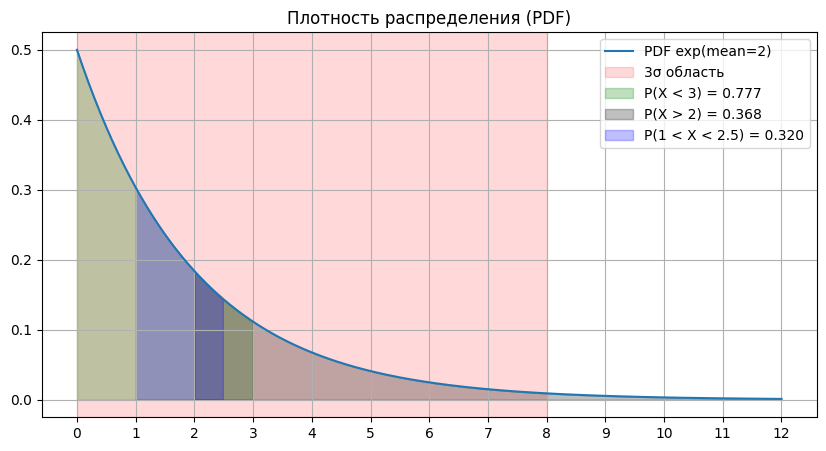

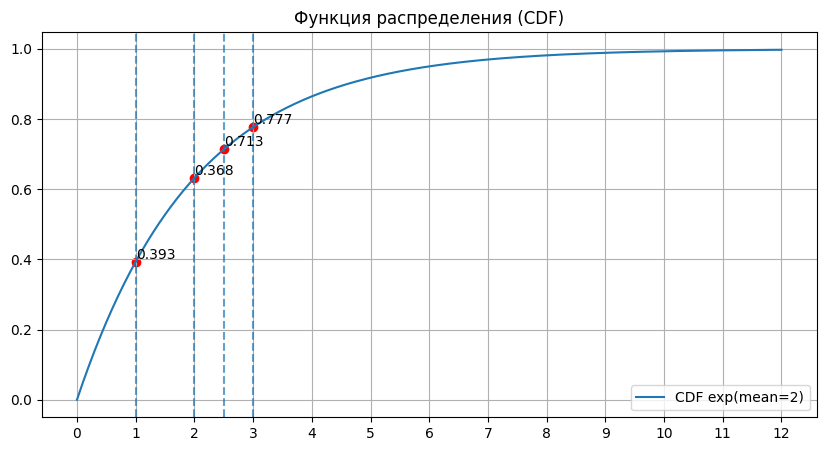

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon

mean = 2  #  M[Y]
lam = 1 / mean     # λ = 1 / M[Y]
dist = expon(scale=mean)   # scale = 1 / M[Y]


def exponential_distribution(mean, dist, probabilities=None, x_max=12, points=600):
    if probabilities is None:
        probabilities = [
            ('less', 3),
            ('more', 2),
            ('between', 1, 2.5)
        ]

    x = np.linspace(0, x_max, points)
    pdf_x = dist.pdf(x)
    cdf_x = dist.cdf(x)

    results = {}
    for p in probabilities:
        if p[0] == 'less':         # P(X < b)
            b = p[1]
            val = dist.cdf(b)
            results[f"P(X < {b})"] = val

        elif p[0] == 'more':       # P(X > a)
            a = p[1]
            val = 1 - dist.cdf(a)
            results[f"P(X > {a})"] = val

        elif p[0] == 'between':    # P(a < X < b)
            a, b = p[1], p[2]
            val = dist.cdf(b) - dist.cdf(a)
            results[f"P({a} < X < {b})"] = val

        else:
            raise ValueError("Unknown command for probabilities")

    # правило 3-сигм
    sigma = mean
    left_3 = max(0, mean - 3 * sigma)
    right_3 = mean + 3 * sigma

    return {
        "x": x,
        "pdf_x": pdf_x,
        "cdf_x": cdf_x,
        "results": results,
        "three_sigma_interval": (left_3, right_3),
        "mean": mean,
        "sigma": sigma
    }

def plot_exponential(data):
    x, pdf_x, cdf_x = data["x"], data["pdf_x"], data["cdf_x"]
    left_3, right_3 = data["three_sigma_interval"]
    mean = data["mean"]
    probs = data["results"]

    prob_colors = {
        "less": "green",
        "more": "black",
        "between": "blue"
    }

    # PDF
    plt.figure(figsize=(10, 5))  # рабочая область
    plt.plot(x, pdf_x, label=f"PDF exp(mean={mean})")  # отображение кривой
    plt.locator_params(axis='x', nbins=15)

    # область правила трех сигм
    plt.axvspan(left_3, right_3, color='red', alpha=0.15, label="3σ область")

    # отображение вероятностей на PDF
    for key, value in probs.items():
        # P(X < b)
        if key.startswith("P(X <"):
            b = float(key.split("<")[1].rstrip(")"))
            mask = x < b
            plt.fill_between(x, pdf_x, where=mask, alpha=0.25,
                            color=prob_colors["less"], label=f"{key} = {value:.3f}")
        # P(X > a)
        elif key.startswith("P(X >"):
            a = float(key.split(">")[1].rstrip(")"))
            mask = x > a
            plt.fill_between(x, pdf_x, where=mask, alpha=0.25,
                            color=prob_colors["more"], label=f"{key} = {value:.3f}")
        # P(a < X < b)
        elif "< X <" in key:
            a, b = key.replace("P(", "").replace(")", "").split(" < X < ")
            a, b = float(a), float(b)
            mask = (x >= a) & (x <= b)
            plt.fill_between(x, pdf_x, where=mask, alpha=0.25,
                            color=prob_colors["between"], label=f"{key} = {value:.3f}")

    plt.title("Плотность распределения (PDF)")
    plt.legend()
    plt.grid()
    plt.show()


    # CDF
    plt.figure(figsize=(10, 5))
    plt.plot(x, cdf_x, label=f"CDF exp(mean={mean})")
    plt.locator_params(axis='x', nbins=15)

    # отображение вероятностей на CDF
    for key, value in probs.items():
        # P(X < b)
        if key.startswith("P(X <"):
            b = float(key.split("<")[1].rstrip(")"))
            y = expon(scale=mean).cdf(b)
            plt.axvline(b, ls="--", alpha=0.7)
            plt.scatter([b], [y], color="red")
            plt.text(b, y, f"{value:.3f}", va="bottom")
        # P(X > a)
        elif key.startswith("P(X >"):
            a = float(key.split(">")[1].rstrip(")"))
            y = expon(scale=mean).cdf(a)
            plt.axvline(a, ls="--", alpha=0.7)
            plt.scatter([a], [y], color="red")
            plt.text(a, y, f"{value:.3f}", va="bottom")
        # P(a < X < b)
        elif "< X <" in key:
            a, b = key.replace("P(", "").replace(")", "").split(" < X < ")
            a, b = float(a), float(b)
            y1 = expon(scale=mean).cdf(a)
            y2 = expon(scale=mean).cdf(b)

            plt.axvline(a, ls="--", alpha=0.7)
            plt.axvline(b, ls="--", alpha=0.7)
            plt.scatter([a], [y1], color="red")
            plt.scatter([b], [y2], color="red")
            plt.text(a, y1, f"{y1:.3f}", va="bottom")
            plt.text(b, y2, f"{y2:.3f}", va="bottom")

    plt.title("Функция распределения (CDF)")
    plt.legend()
    plt.grid()
    plt.show()

data = exponential_distribution(mean, dist)
print(data)
plot_exponential(data)